In [28]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
df = pd.read_csv('../../data/Database_Cleaned.csv')

df['Release_Quarter'] = df['Month'].apply(lambda x: (x-1)//3 + 1 if pd.notna(x) else np.nan)
df['Is_Summer_Release'] = df['Month'].apply(lambda x: 1 if x in [6, 7, 8] else 0)
df['Is_Holiday_Release'] = df['Month'].apply(lambda x: 1 if x in [11, 12] else 0)
df['Votes_Per_Point'] = df['Vote_Count'] / (df['Vote_Average'] + 0.01) # Avoid division by zero

In [10]:
labelEncode = LabelEncoder()

# Encode language
df['Language_Encoded'] = labelEncode.fit_transform(df['Original_Language'].fillna('unknown'))

# Encode primary genre
df['Genre_Encoded'] = labelEncode.fit_transform(df['Primary_Genre'])

In [11]:
df.head()

,Release_Date,Title,Overview,Popularity,Vote_Count,Vote_Average,Original_Language,Genre,Poster_Url,Year,...,Has_Poster,Genre_List,Genre_Count,Primary_Genre,Release_Quarter,Is_Summer_Release,Is_Holiday_Release,Votes_Per_Point,Language_Encoded,Genre_Encoded
0,2021-12-15,Spider-Man: No Way Home,Peter Parker is unmasked and no longer able to...,5083.954,8940.0,8.3,en,"Action, Adventure, Science Fiction",https://image.tmdb.org/t/p/original/1g0dhYtq4i...,2021.0,...,True,"['Action', 'Adventure', 'Science Fiction']",3,Action,4.0,0,1,1075.812274,8,0
1,2022-03-01,The Batman,"In his second year of fighting crime, Batman u...",3827.658,1151.0,8.1,en,"Crime, Mystery, Thriller",https://image.tmdb.org/t/p/original/74xTEgt7R3...,2022.0,...,True,"['Crime', 'Mystery', 'Thriller']",3,Crime,1.0,0,0,141.923551,8,4
2,2022-02-25,No Exit,Stranded at a rest stop in the mountains durin...,2618.087,122.0,6.3,en,Thriller,https://image.tmdb.org/t/p/original/vDHsLnOWKl...,2022.0,...,True,['Thriller'],1,Thriller,1.0,0,0,19.334390,8,16
3,2021-11-24,Encanto,"The tale of an extraordinary family, the Madri...",2402.201,5076.0,7.7,en,"Animation, Comedy, Family, Fantasy",https://image.tmdb.org/t/p/original/4j0PNHkMr5...,2021.0,...,True,"['Animation', 'Comedy', 'Family', 'Fantasy']",4,Animation,4.0,0,1,658.365759,8,2
4,2021-12-22,The King's Man,As a collection of history's worst tyrants and...,1895.511,1793.0,7.0,en,"Action, Adventure, Thriller, War",https://image.tmdb.org/t/p/original/aq4Pwv5Xeu...,2021.0,...,True,"['Action', 'Adventure', 'Thriller', 'War']",4,Action,4.0,0,1,255.777461,8,0


# PREDICT VOTE AVERAGE (RATINGS)

In [14]:
# Features for regression
feature_cols = ['Popularity', 'Vote_Count', 'Genre_Count', 'Year', 'Month',
                'Language_Encoded', 'Genre_Encoded', 'Is_Summer_Release',
                'Is_Holiday_Release']

# Prepare data
df_regression = df.dropna(subset=['Vote_Average'] + feature_cols)
X_reg = df_regression[feature_cols]
y_reg = df_regression['Vote_Average']

print(f"Samples: {len(X_reg)}")
print(f"Features: {len(feature_cols)}")
print(f"Target: Vote_Average (Range: {y_reg.min():.2f} - {y_reg.max():.2f})")

Samples: 9827
Features: 9
Target: Vote_Average (Range: 0.00 - 10.00)


In [18]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Scale features
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

In [21]:
models_reg = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

results_reg = {}

for name, model in models_reg.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_reg_scaled, y_train_reg)

    # Predictions
    y_pred_train = model.predict(X_train_reg_scaled)
    y_pred_test = model.predict(X_test_reg_scaled)

    # Metrics
    train_mse = mean_squared_error(y_train_reg, y_pred_train)
    test_mse = mean_squared_error(y_test_reg, y_pred_test)
    train_mae = mean_absolute_error(y_train_reg, y_pred_train)
    test_mae = mean_absolute_error(y_test_reg, y_pred_test)
    train_r2 = r2_score(y_train_reg, y_pred_train)
    test_r2 = r2_score(y_test_reg, y_pred_test)

    results_reg[name] = {
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train R2': train_r2,
        'Test R2': test_r2,
        'Model': model
    }

    print(f"  Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
    print(f"  Train MAE: {train_mae:.4f} | Test MAE: {test_mae:.4f}")


Training Linear Regression...
  Train R²: 0.1242 | Test R²: 0.1286
  Train MAE: 0.7217 | Test MAE: 0.7328

Training Decision Tree...
  Train R²: 0.6500 | Test R²: 0.5800
  Train MAE: 0.4944 | Test MAE: 0.5666

Training Random Forest...
  Train R²: 0.6789 | Test R²: 0.6275
  Train MAE: 0.4820 | Test MAE: 0.5355

Training Gradient Boosting...
  Train R²: 0.7091 | Test R²: 0.6560
  Train MAE: 0.4586 | Test MAE: 0.5154


In [25]:
# Compare models
comparison_reg = pd.DataFrame({
    'Model': list(results_reg.keys()),
    'Test R²': [v['Test R2'] for v in results_reg.values()],
    'Test MAE': [v['Test MAE'] for v in results_reg.values()],
    'Test MSE': [v['Test MSE'] for v in results_reg.values()]
})
comparison_reg = comparison_reg.sort_values('Test R²', ascending=False)
print(comparison_reg.to_string(index=False))

# Best model
best_model_reg_name = comparison_reg.iloc[0]['Model']
best_model_reg = results_reg[best_model_reg_name]['Model']
print(f"\nBest Model: {best_model_reg_name}")
print(f"Test R²: {results_reg[best_model_reg_name]['Test R2']:.4f}")
print(f"Test MAE: {results_reg[best_model_reg_name]['Test MAE']:.4f}")

            Model  Test R²  Test MAE  Test MSE
Gradient Boosting 0.655982  0.515364  0.468326
    Random Forest 0.627550  0.535525  0.507032
    Decision Tree 0.579958  0.566622  0.571821
Linear Regression 0.128632  0.732814  1.186229

Best Model: Gradient Boosting
Test R²: 0.6560
Test MAE: 0.5154


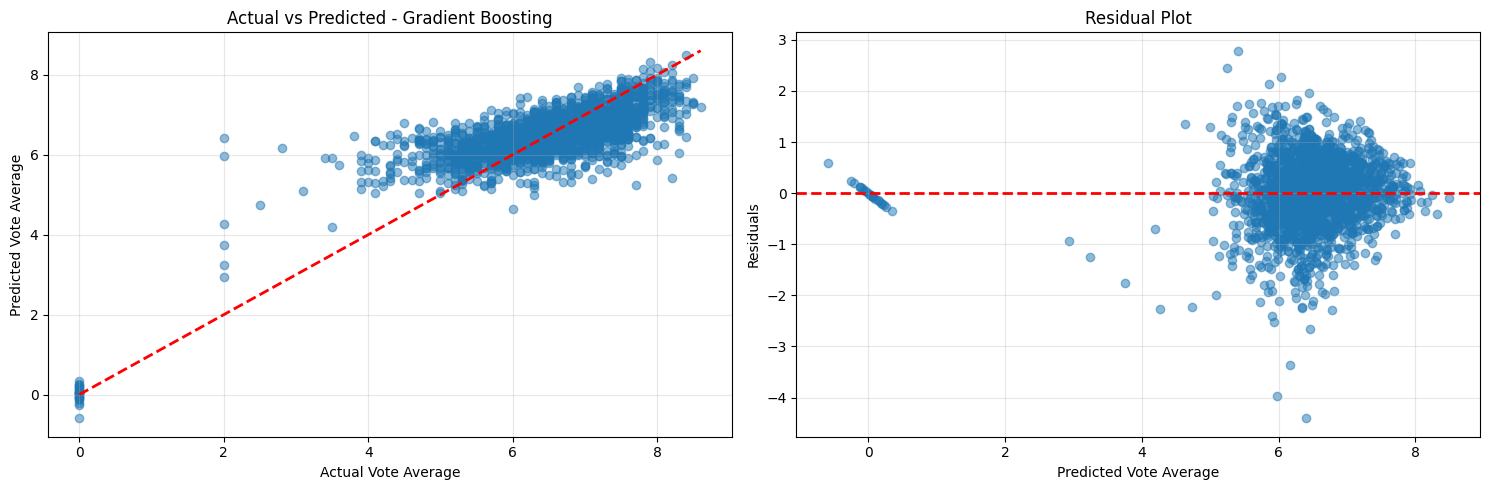

In [30]:
y_pred_best = best_model_reg.predict(X_test_reg_scaled)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# Actual vs Predicted
axes[0].scatter(y_test_reg, y_pred_best, alpha=0.5)
axes[0].plot([y_test_reg.min(), y_test_reg.max()],
             [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Vote Average')
axes[0].set_ylabel('Predicted Vote Average')
axes[0].set_title(f'Actual vs Predicted - {best_model_reg_name}')
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = y_test_reg - y_pred_best
axes[1].scatter(y_pred_best, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Vote Average')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Top 10 Important Features:
           Feature  Importance
        Vote_Count    0.635051
     Genre_Encoded    0.107077
              Year    0.100174
  Language_Encoded    0.085424
        Popularity    0.041048
       Genre_Count    0.015342
             Month    0.014264
 Is_Summer_Release    0.001524
Is_Holiday_Release    0.000097


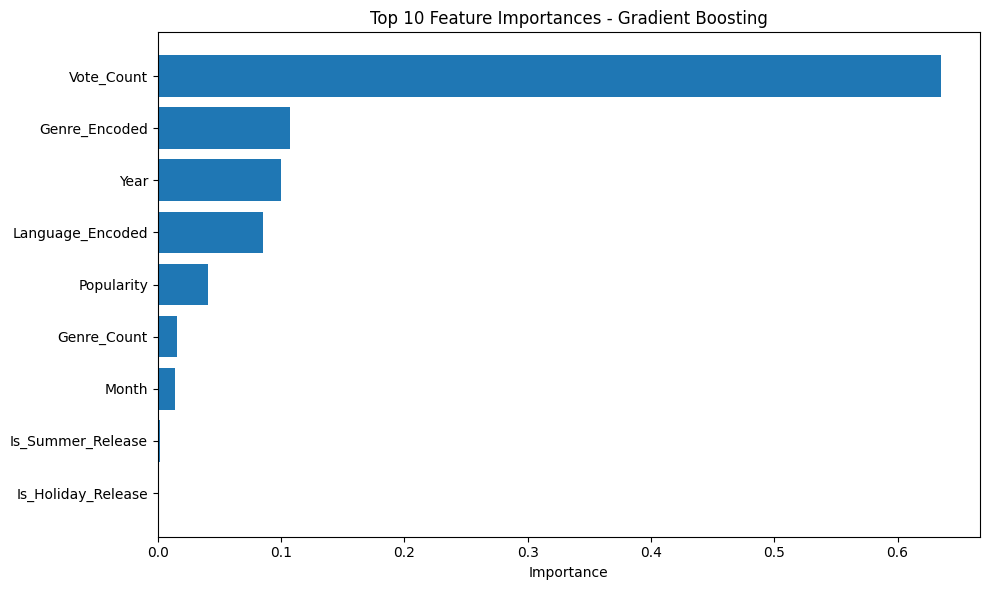

In [31]:
if hasattr(best_model_reg, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model_reg.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 10 Important Features:")
    print(feature_importance.head(10).to_string(index=False))

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance.head(10)['Feature'],
             feature_importance.head(10)['Importance'])
    plt.xlabel('Importance')
    plt.title(f'Top 10 Feature Importances - {best_model_reg_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()